# Importando bibliotecas e extraindo dados

In [ ]:
!pip install python-bcb

!pip install workadays

!pip install workalendar

!pip install --upgrade --no-cache-dir git+https://github.com/rongardF/tvdatafeed.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 60.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.7/210.7 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.9/47.9 kB 2.9 MB/s eta 0:00:00
  Created wheel for pymeeus: filename=PyMeeus-0.5.12-py3-none-any.whl size=732003 sha256=38a45c57a61c125813e22783b23bef37ebc413e9eae662ff237d9d17a6f7cbb8
  Stored in directory: /root/.cache/pip/wheels/d6/67/78/aa2e8d108639dd23a5e9e72a4fc88bb44f5541894382712f48
Successfully built pymeeus
  Cloning https://github.com/rongardF/tvdatafeed.git to /tmp/pip-req-build-ql81_e3i
  Running command git clone --filter=blob:none --quiet https://github.com/rongardF/tvdatafeed.git /tmp/pip-req-build-ql81_e3i
  Resolved https://github.com/rongardF/tvdatafeed.git to commit e6f6aaa7de439ac6e454d9b26d2760ded8dc4923
  Preparing metadata (setup.py) ... done
  Created wheel for tvdatafeed: filename=tvdatafeed-2.1.0-py3-none-any.whl si

In [ ]:
import numpy as np
import pandas as pd
import datetime

from scipy.stats import norm
from workalendar.america import Brazil
from matplotlib import pyplot as plt
from scipy.optimize import minimize
from bcb import sgs
from workadays import workdays as wd
from tvDatafeed import TvDatafeed, Interval

In [ ]:
#Definindo a função DI do derivativo
def di(cdi, taxa, prob_taxa, du1, du2):
  """Retorna a taxa DI para o dia du1 + du2

  ----------
  parameters:

  cdi: taxa cdi vigente
  taxa: vetor de possivéis mudanças de taxas
  prob_taxa: vetor de probabilidades das taxas
  du1: Quantidade de dias até a reunião do copom
  du2: Quantidade de dias após 1 dia da reunião do copom até o vencimento do contrato

  return: int
  """

  pre_copom = (1+cdi)**(du1/252)
  pos_copom = (1 + cdi + taxa@prob_taxa) ** (du2/252)

  return ((pre_copom * pos_copom)**(252/(du1+du2))) - 1

In [ ]:
#cdi = 12.5 / 100
cdis = sgs.get({'CDI over': 432}, start = '2010-01-01')
cdi1 = cdis.select_dtypes(include = 'float')
cdi1

,CDI over
Date,
2010-01-01,8.75
2010-01-02,8.75
2010-01-03,8.75
2010-01-04,8.75
2010-01-05,8.75
...,...
2024-11-28,11.25
2024-11-29,11.25
2024-11-30,11.25


In [ ]:
contador = 0

for linha in cdi1.index:

  if linha == '2018-08-18':
    break
  contador += 1

contador

5450

In [ ]:
def simplex(n):   # Método de sorteio em um simplexo. Possui distribuição uniforme.
    """Gera um array no Rn, de forma uniforme, onde suas entradas somam 1
    n -> array"""
    aleatorio = [0]
    for _ in range(1, n):
        aleatorioi = np.random.rand()  # Gero números entre [0, 1) uniformemente
        aleatorio.append(aleatorioi)    # Os adiciono a lista.
    aleatorio.sort()                    # Ordeno-a
    aleatorio.append(1)

    pesos = np.array(aleatorio[1:]) - np.array(aleatorio[:-1])

    return pesos

In [ ]:
tres_simplex = []
x, y, z = [], [], []

for i in range(1000):
  a = simplex(3)
  tres_simplex.append(a)


for simplex_1 in tres_simplex:
  x.append(simplex_1[0])
  y.append(simplex_1[1])
  z.append(simplex_1[2])

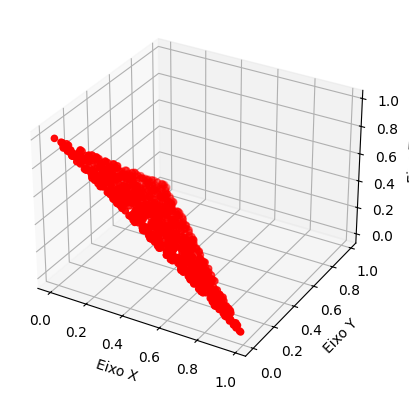

In [ ]:
# Criação da figura 3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plotagem dos pontos em 3D
ax.scatter(x, y, z, c='r', marker='o')

# Configurações adicionais, se necessário
ax.set_xlabel('Eixo X')
ax.set_ylabel('Eixo Y')
ax.set_zlabel('Eixo Z')

# Exibição da figura
plt.show()

In [ ]:
def pts_n_simplex(num_n_simplex, num_vec = 400):
  """
  Cria um array que contem uma quantidade num_vec de pontos do n_simplex

  ----------
  parameters:

  num_n_simplex: Dimensão do nosso espaço simplético
  num_vec: número de vetores

  """

  pts_n_simplex = []

  for _ in range(num_vec):
    pts = simplex(num_n_simplex)
    pts_n_simplex.append(pts)

  return pts_n_simplex

Usando o contato DI1N2024

Contrato de Futuro de DI com vencimento em 01/07/2024. Peguei esse contrato pois tem uma série histórica de preços desde 2013. Iremos usar o período de 03 novembro (1º dia pós reunião do copom feita em 02 de novembro) e 13 de dezembro (último dia antes da taxa DI ser mudada pela reunião desse dia)


Importando os dados do contrato futuro DI1

In [ ]:
theta = np.array([-0.5/100, -0.25/100, 0]) # vetor de possíveis mudanças

In [ ]:
def dias_uteis(data_inicial, data_final):
  """Retorna a quantidade de dias úteis entre duas datas fornecidas"""

  cal = Brazil()

  # Obtém a lista de datas entre data_inicial e data_final
  datas = [data_inicial + datetime.timedelta(days=x) for x in range((data_final - data_inicial).days + 1)]

  # Filtra apenas os dias úteis (excluindo sábados, domingos e feriados)
  dias_uteis = [d for d in datas if cal.is_working_day(d)]

  return len(dias_uteis)

In [ ]:
# Dados de Mercado e alguns parâmetros
d1 = datetime.date(2018, 9, 19) # Data do dia seguinte da reunião do copom
d2 = datetime.date(2018, 10, 1)  # Data do vencimento do contrato

du2_t = dias_uteis(d1, d2)
du2_t

9

In [ ]:
tv = TvDatafeed()

*Vamos usar como base que a pontuação do IDI foi reinicializada no dia 2008-11-13

In [ ]:
# Preços de mercado
DI_index_data1 = tv.get_hist(symbol ='DI11!',exchange = 'BMFBOVESPA', interval=Interval.in_daily, n_bars = 3768) # Séries de preços da DI11

datas1 = [dt.strftime('%Y-%m-%d') for dt in DI_index_data1.index] # Dias no formato YYYY-MM-DD da série de preços da DI11
DI_index_data1.index = datas1 # Indexando com os dias no formato YYYY-MM-DD

market_di1 = DI_index_data1.loc[datas1] # Informações de mercado da DI11
prices_di_hist_1 = market_di1['close'] # Preços de fechamento da DI11
prices_di_2 = market_di1[2347:2380]['close']

print(datas1)

['2009-09-17', '2009-09-18', '2009-09-21', '2009-09-22', '2009-09-23', '2009-09-24', '2009-09-25', '2009-09-28', '2009-09-29', '2009-09-30', '2009-10-01', '2009-10-02', '2009-10-05', '2009-10-06', '2009-10-07', '2009-10-08', '2009-10-09', '2009-10-13', '2009-10-14', '2009-10-15', '2009-10-16', '2009-10-19', '2009-10-20', '2009-10-21', '2009-10-22', '2009-10-23', '2009-10-26', '2009-10-27', '2009-10-28', '2009-10-29', '2009-10-30', '2009-11-03', '2009-11-04', '2009-11-05', '2009-11-06', '2009-11-09', '2009-11-10', '2009-11-11', '2009-11-12', '2009-11-13', '2009-11-16', '2009-11-17', '2009-11-18', '2009-11-19', '2009-11-23', '2009-11-24', '2009-11-25', '2009-11-26', '2009-11-27', '2009-11-30', '2009-12-01', '2009-12-02', '2009-12-03', '2009-12-04', '2009-12-07', '2009-12-08', '2009-12-09', '2009-12-10', '2009-12-11', '2009-12-14', '2009-12-15', '2009-12-16', '2009-12-17', '2009-12-18', '2009-12-21', '2009-12-22', '2009-12-23', '2009-12-28', '2009-12-29', '2009-12-30', '2010-01-04', '2010

In [ ]:
# Preços de mercado
DI_index_data = tv.get_hist(symbol ='DI1V2018',exchange = 'BMFBOVESPA', interval=Interval.in_daily, n_bars = 42) # Séries de preços da DI11

datas = [dt.strftime('%Y-%m-%d') for dt in DI_index_data.index] # Dias no formato YYYY-MM-DD da série de preços da DI11
DI_index_data.index = datas # Indexando com os dias no formato YYYY-MM-DD

In [ ]:
market_di = DI_index_data.loc[datas].head(33) # Informações de mercado da DI11
prices_di = market_di['close'] # Preços de abertura da DI11
datas_prob = market_di.index

In [ ]:
index_remov = ~cdi1.index.isin(datas_prob)

cdi_s = cdi1.loc[~index_remov]
cdi_s.index

<ipython-input-17-b9930b2f3ac3>:1: FutureWarning: The behavior of 'isin' with dtype=datetime64[ns] and castable values (e.g. strings) is deprecated. In a future version, these will not be considered matching by isin. Explicitly cast to the appropriate dtype before calling isin instead.
  index_remov = ~cdi1.index.isin(datas_prob)


DatetimeIndex(['2018-08-01', '2018-08-02', '2018-08-03', '2018-08-06',
               '2018-08-07', '2018-08-08', '2018-08-09', '2018-08-10',
               '2018-08-13', '2018-08-14', '2018-08-15', '2018-08-16',
               '2018-08-17', '2018-08-20', '2018-08-21', '2018-08-22',
               '2018-08-23', '2018-08-24', '2018-08-27', '2018-08-28',
               '2018-08-29', '2018-08-30', '2018-08-31', '2018-09-03',
               '2018-09-04', '2018-09-05', '2018-09-06', '2018-09-10',
               '2018-09-11', '2018-09-12', '2018-09-13', '2018-09-14',
               '2018-09-17'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [ ]:
cdi_s = cdi_s['CDI over'].to_numpy() # Convertendo para array
prices_di = prices_di.to_numpy() # Convertendo para array

In [ ]:
def di_model(Q, market_price , cdi , du1 , du2 , theta , gamma, Q_prev):
    model_price = di(cdi, theta, Q, du1, du2)
    #print(1/2 * ((market_price - model_price)**2), " - ", gamma * np.linalg.norm(Q - Q_prev))
    return 1/2 * ((market_price - 100*model_price)**2) + gamma * np.linalg.norm(Q - Q_prev)

# Código alternativo

In [ ]:
n_simplex = pts_n_simplex(len(theta), 100000)

In [ ]:
Q_s = []

for t in range(len(datas_prob)):

  market_price_t = prices_di[t] # Preço de mercado da DI
  cdi_t = cdi_s[t]/100 # preço da cdi no dia t
  du1_t = len(datas_prob) - t  # Dias até a reunião do copom

  print(t, datas_prob[t], 'du1:', du1_t, 'du2:', du2_t, 'cdi:', cdi_t)

  if t == 0:
    gamma = 1e-5 #Parâmetro de regularização
    Q_prev = np.array([0.07, 0.13, 0.8])

  else:
    gamma = 1e-5 # Parâmetro de regularização

  min_value = 1e16 #Valor grande o suficiente para não passar no primeiro if do for abaixo

  for i, Q0 in enumerate(n_simplex):

    y = di_model(Q0, market_price_t , cdi_t , du1_t , du2_t , theta , gamma, Q_prev)

    if y < min_value:
      min_value = y
      Q_min = Q0
      #print(' mercado: ', market_price_t, ' modelo: ', 100*di(cdi_t, theta, Q_min, du1_t, du2_t), ' Q_min: ', Q_min, ' objective: ', 1/2 * ((market_price_t - 100*di(cdi_t, theta, Q_min, du1_t, du2_t))**2) + gamma * np.linalg.norm(Q_min - Q_prev) )


  if t!= -1:
    Q_s.append(Q_min)

  Q_prev = Q_min

0 2018-08-01 du1: 33 du2: 9 cdi: 0.065
1 2018-08-02 du1: 32 du2: 9 cdi: 0.065
2 2018-08-03 du1: 31 du2: 9 cdi: 0.065
3 2018-08-06 du1: 30 du2: 9 cdi: 0.065
4 2018-08-07 du1: 29 du2: 9 cdi: 0.065
5 2018-08-08 du1: 28 du2: 9 cdi: 0.065
6 2018-08-09 du1: 27 du2: 9 cdi: 0.065
7 2018-08-10 du1: 26 du2: 9 cdi: 0.065
8 2018-08-13 du1: 25 du2: 9 cdi: 0.065
9 2018-08-14 du1: 24 du2: 9 cdi: 0.065
10 2018-08-15 du1: 23 du2: 9 cdi: 0.065
11 2018-08-16 du1: 22 du2: 9 cdi: 0.065
12 2018-08-17 du1: 21 du2: 9 cdi: 0.065
13 2018-08-20 du1: 20 du2: 9 cdi: 0.065
14 2018-08-21 du1: 19 du2: 9 cdi: 0.065
15 2018-08-22 du1: 18 du2: 9 cdi: 0.065
16 2018-08-23 du1: 17 du2: 9 cdi: 0.065
17 2018-08-24 du1: 16 du2: 9 cdi: 0.065
18 2018-08-27 du1: 15 du2: 9 cdi: 0.065
19 2018-08-28 du1: 14 du2: 9 cdi: 0.065
20 2018-08-29 du1: 13 du2: 9 cdi: 0.065
21 2018-08-30 du1: 12 du2: 9 cdi: 0.065
22 2018-08-31 du1: 11 du2: 9 cdi: 0.065
23 2018-09-03 du1: 10 du2: 9 cdi: 0.065
24 2018-09-04 du1: 9 du2: 9 cdi: 0.065
25 2018-09-

In [ ]:
datas_prob = datas_prob[15:]

In [ ]:
bps_50 = np.zeros(len(Q_s))
bps_25 = np.zeros(len(Q_s))
bps_0 = np.zeros(len(Q_s))

for i, Q in enumerate(Q_s):
  bps_50[i] = Q[0]
  bps_25[i] = Q[1]
  bps_0[i]  = Q[2]

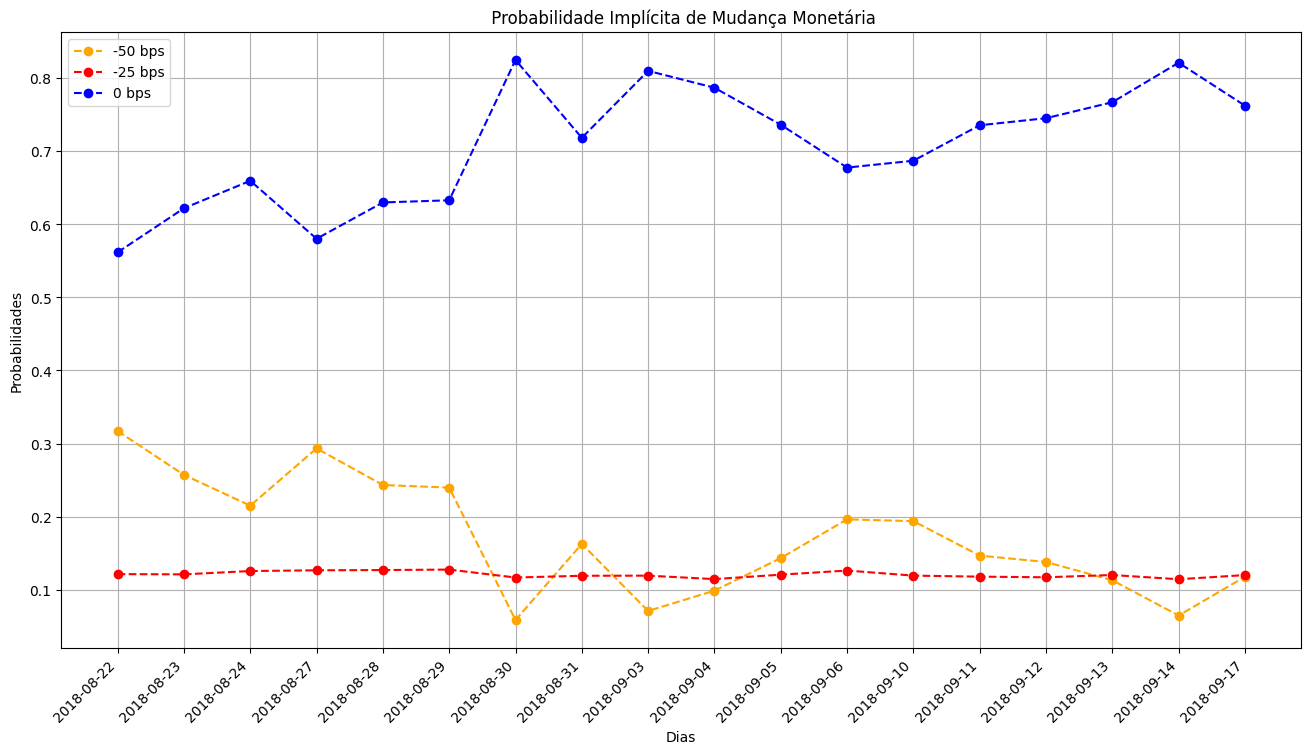

In [ ]:
plt.figure(figsize=(16, 8))
plt.plot(datas_prob,bps_50[15:] , marker='o', linestyle='--', label = '-50 bps', color = 'orange')
plt.plot(datas_prob,bps_25[15:] , marker='o', linestyle='--', label = '-25 bps', color = 'red')
plt.plot(datas_prob,bps_0[15:] , marker='o', linestyle='--',  label = '0 bps', color = 'blue')

# Configurar rótulos e título
plt.xlabel('Dias')
plt.ylabel('Probabilidades')
plt.title(' Probabilidade Implícita de Mudança Monetária')

# Exibir o gráfico
plt.grid()
plt.legend()
plt.xticks(rotation=45, ha='right')
plt.show()

#Apreçamento

In [ ]:
#Descobre o preço atual a partir do dia inicial (dado pelo Lucas Paiva)
serie_acumulada2 = []
num = 100000

for i, di1 in enumerate(prices_di_hist_1):
  serie_acumulada2.append((num, datas1[i]))
  num *= (1 + di1/100)**(1/252)


In [ ]:
for tupla in serie_acumulada2:
  if tupla[1] == '2018-08-01':
    print(tupla)

(243041.31777293055, '2018-08-01')


In [ ]:
#Descobre o preço atual a partir do dia inicial (dado pelo Lucas Paiva)
serie_acumulada = np.zeros(len(prices_di_hist_1))
num = 100000

for i, di1 in enumerate(prices_di_hist_1):
  serie_acumulada[i] = num
  num *= (1 + di1/100)**(1/252)

In [ ]:
serie_acumulada

array([100000.        , 100032.89012104, 100065.75450733, ...,
       394320.79689555, 394486.25770452, 394651.77385272])

In [ ]:
def esta_em_ordem_crescente(lista):
  """Verifica se os números em uma lista estão em ordem crescente.

  Args:
    lista: A lista de números a serem verificados.

  Returns:
    True se os números estiverem em ordem crescente, False caso contrário.
  """
  for i in range(len(lista) - 1):
    if lista[i] > lista[i + 1]:
      return False
  return True

# Exemplo de uso

if esta_em_ordem_crescente(serie_acumulada):
  print("Os números estão em ordem crescente.")
else:
  print("Os números não estão em ordem crescente.")

Os números estão em ordem crescente.


In [ ]:
serie_idi = pd.DataFrame({'Data': datas1, 'IDI': serie_acumulada})
serie_idi = serie_idi.set_index('Data')
serie_idi

,IDI
Data,
2009-09-17,100000.000000
2009-09-18,100032.890121
2009-09-21,100065.754507
2009-09-22,100098.702816
2009-09-23,100131.552244
...,...
2024-11-26,393989.999053
2024-11-27,394155.363271
2024-11-28,394320.796896


In [ ]:
# Dia para teste: 05/09/2018

def P(taxa, prob_taxa, du1, du2, cdi_t):
  d_i_1 = di(cdi_t, taxa, prob_taxa, du1, du2)

  return 1/(1 + d_i_1**((du1+du2)/252))

In [ ]:
def idi_futuro(idi_t, cdi_t, taxa, prob_taxa, du1, du2):
  idi_reuniao = idi_t*(1 + cdi_t)**(du1/252)

  return idi_reuniao*(1 + cdi_t + taxa@prob_taxa)**(du2/252)

In [ ]:
def price_black(taxa, prob_taxa, du1, du2, cdi_t, idi_t, K, sigma):

  P_t = P(taxa, prob_taxa, du1, du2, cdi_t) # Correção da moeda -> juros
  idi_f = idi_futuro(idi_t, cdi_t, taxa, prob_taxa, du1, du2)
  print(idi_f, 'idi_f mercado')

  d1 = (np.log(idi_f/K)  + 0.5*sigma**(2)*(du1+du2))/(sigma*np.sqrt(du1+du2))
  d2 = d1 - sigma*np.sqrt(du1+du2)

  call = P_t * (idi_f*norm.cdf(d1) - K*norm.cdf(d2))
  put  = call - P_t*idi_f + P_t*K  # -> Put_Call Parity

  return call, put

In [ ]:
### Cálculo da Volatilidade
retorno = []

lista_datas = list(datas_prob)
lista_idi = serie_idi.loc[lista_datas, ['IDI']]['IDI'].tolist()

for i in range(0, len(lista_idi)-1):

  ret = (lista_idi[i+1]/lista_idi[i]) - 1
  retorno.append(ret)

vol = np.std(retorno)

vol

1.0547604289234386e-06

In [ ]:
## Descobrindo o indice na série histórica do IDI do dia da reunião do copom do dia 01/08/2018

contador = 0

for linha in market_di1.index:

  if linha == '2018-08-01':
    break
  contador += 1

contador

2192

In [ ]:
vetor_Q = [[bps_50[15:][i], bps_25[15:][i], bps_0[15:][i]] for i in range(len(bps_50[15:]))]
Qs_frame = pd.DataFrame({'Data': datas_prob, 'Vetor_Q': vetor_Q})
Qs_frame = Qs_frame.set_index('Data')

Qs_frame

,Vetor_Q
Data,
2018-08-22,"[0.31708653387287244, 0.12141861134779697, 0.5..."
2018-08-23,"[0.2571051542559203, 0.12110176770140868, 0.62..."
2018-08-24,"[0.21501784495704057, 0.12564077730167256, 0.6..."
2018-08-27,"[0.29331451467609637, 0.12664258630452574, 0.5..."
2018-08-28,"[0.24328445168435475, 0.12698838676348645, 0.6..."
2018-08-29,"[0.23973090262982, 0.12762987356957456, 0.6326..."
2018-08-30,"[0.0586950610205661, 0.11678036551526572, 0.82..."
2018-08-31,"[0.1627268098455824, 0.11917535369476695, 0.71..."
2018-09-03,"[0.07104702215137426, 0.11931457610705642, 0.8..."


In [ ]:
#Precificação do modelo para os dias (1) 09/08/2018, (2) 29/08/2018 e (3) 05/09/2018
sigma = 1.0547604289234386e-06

strikes = [266000, 266100, 266200, 266300]
IDI_reuniao18 = np.round(float(serie_idi.loc[['2018-09-18'], ['IDI']]['IDI']), 2)
datas_model = ['2018-08-22', '2018-08-29', '2018-09-05']


Q_is = Qs_frame.loc[datas_model, ['Vetor_Q']]

IDIs = [(IDI_reuniao18*(1 + 0.0625 + theta@Q_i)**( (du2_t/100) / 252 ), Q_i, 18-(5*i) ) for i,Q_i in enumerate(Q_is['Vetor_Q'].tolist())]

resultados_model = np.zeros([3, 4])

for a, modeli in enumerate(IDIs):
  for b, strike in enumerate(strikes):
    model = price_black(theta, modeli[1], modeli[2], 31, 0.0625, modeli[0], strike, sigma)[1]
    resultados_model[a][b] = model

247883.2097805222 idi_f mercado
247883.2097805222 idi_f mercado
247883.2097805222 idi_f mercado
247883.2097805222 idi_f mercado
247595.9081594902 idi_f mercado
247595.9081594902 idi_f mercado
247595.9081594902 idi_f mercado
247595.9081594902 idi_f mercado
247312.61686945683 idi_f mercado
247312.61686945683 idi_f mercado
247312.61686945683 idi_f mercado
247312.61686945683 idi_f mercado


<ipython-input-37-b2485ffd6816>:5: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  IDI_reuniao18 = np.round(float(serie_idi.loc[['2018-09-18'], ['IDI']]['IDI']), 2)


In [ ]:
model_frame = pd.DataFrame({'Strike': strikes, 'Model (2018-08-22)': resultados_model[0], 'Model (2018-08-29)': resultados_model[1], 'Model (2018-09-05)': resultados_model[2]})
model_frame

,Strike,Model (2018-08-22),Model (2018-08-29),Model (2018-09-05)
0,266000,11458.502629,11399.990162,11327.141218
1,266100,11521.750602,11461.932855,11387.755062
2,266200,11584.998575,11523.875549,11448.368906
3,266300,11648.246548,11585.818242,11508.982749


In [ ]:
#Precificação do modelo para os dias (1) 09/08/2018, (2) 29/08/2018 e (3) 05/09/2018


strikes = [260000, 260100, 260200, 260300]
IDI_reuniao18 = np.round(float(serie_idi.loc[['2018-09-18'], ['IDI']]['IDI']), 2)
datas_model = ['2018-08-22', '2018-08-29', '2018-09-05']


Q_is = Qs_frame.loc[datas_model, ['Vetor_Q']]

IDIs = [IDI_reuniao18*(1 + 0.0625 + theta@Q_i)**( (du2_t/100) / 252 ) for Q_i in Q_is['Vetor_Q'].tolist()]

resultados_model = np.zeros([3, 4])

for a, idi_modeli in enumerate(IDIs):
  for b, strike in enumerate(strikes):
    model = np.max(strike-idi_modeli, 0)
    resultados_model[a][b] = model

<ipython-input-39-326742665036>:5: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  IDI_reuniao18 = np.round(float(serie_idi.loc[['2018-09-18'], ['IDI']]['IDI']), 2)


In [ ]:
model_frame = pd.DataFrame({'Strike': strikes, 'Model (2018-08-09)': resultados_model[0], 'Model (2018-08-29)': resultados_model[1], 'Model (2018-09-05)': resultados_model[2]})
model_frame

,Strike,Model (2018-08-09),Model (2018-08-29),Model (2018-09-05)
0,260000,14968.08043,14968.049804,14968.00863
1,260100,15068.08043,15068.049804,15068.00863
2,260200,15168.08043,15168.049804,15168.00863
3,260300,15268.08043,15268.049804,15268.00863
